In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
#from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import ndimage
from datetime import datetime

In [2]:
def set_white_color(original_cmap):
    # Get the colors from the original colormap
    clrs = original_cmap(np.linspace(0, 1, original_cmap.N))
    # Set the first color to white
    clrs[0, :] = [1, 1, 1, 1] #RGBA values for white
    # Create a new colormap
    new_cmap = colors.ListedColormap(clrs)
    return(new_cmap)


def array_to_xarray(array,xarray):
    """
    scipy.ndimage converts xarray to array, this function reverts it back to xarray
    """
    new_xarray = xr.DataArray(
        array,
        dims=xarray.dims,  
        coords=xarray.coords,  
        attrs=xarray.attrs,
    )
    return new_xarray

def label_clusters(data_array, structure=None):
    """
    Defines clusters in data_array and labels it. Structure can be given to change how ndimage clusters points together.
    """
    labeled_array, num_features = ndimage.label(data_array.values, structure=structure) #num_features is ignored
    labeled_xarray = array_to_xarray(labeled_array,data_array)
    return labeled_xarray

def area_weights(data_array,latitude_dim_name='latitude',R = 6371):
    """
    Area of one grid cell (assuming spatial resolution is 0.25 x 0.25)
    """
    #R = 6371 km^2
    return (R**2)*np.deg2rad(0.25)*np.deg2rad(0.25)*np.cos(np.deg2rad(data_array[latitude_dim_name]))#np.cos(data_array[latitude_dim_name]*np.pi/180)

def filter_clusters_by_area(data_array,latitude_dim_name='latitude',AREA_THRESHOLD=500):
    ds_temp = xr.Dataset({'labels': data_array})
    ds_temp['area'] = area_weights(data_array,latitude_dim_name=latitude_dim_name)    
    label_areas= ds_temp.groupby('labels').sum() 
    labels_to_keep = label_areas.where(label_areas>AREA_THRESHOLD,drop=True)
    labels_to_keep = labels_to_keep['labels'].values
    labels_to_keep = labels_to_keep[labels_to_keep>0]
    if len(labels_to_keep) == 0:
        data_array[:] = 0
    else:
        data_array = data_array.isin(labels_to_keep).astype(int)
    return data_array

def apply_binary_morph(data_array,s=np.ones((3,3)),method='dilation'):
    """
    Apply binary structure (s) to data_array using one of the methods available ['dilation','erosion','closing','fill_holes']
    data_array and s must have the same number of dimensions
    """
    if len(data_array.shape) != len(s.shape):
        print("No morphology change: data array and structure have different shapes")
        return(data_array)
    if method not in ['dilation','erosion','closing','fill_holes']:
        print("No morphology change: methods needs to be one of ['dilation','erosion','closing','fill_holes']")
        return(data_array)
    if method=='dilation':
        binary_transformation = ndimage.binary_dilation(data_array,structure=s).astype(int)
    elif method =='erosion':
        binary_transformation = ndimage.binary_erosion(data_array,structure=s).astype(int)
    elif method == 'closing':
        binary_transformation = ndimage.binary_closing(data_array,structure=s).astype(int)
    elif method == 'fill_holes':
        binary_transformation = ndimage.binary_fill_holes(data_array,structure=s).astype(int)
    return array_to_xarray(array=binary_transformation,xarray=data_array)

In [3]:
#PARAMETERS
STDEV_THRESHOLD = -1.5
SMALL_BLOBS_FILTER = 50
AREA_THRESHOLD=500000#in km^2
VARIABLE = 'anomaly_scaled'

In [4]:
ds = xr.open_dataset("temp/era5_t2min_scaled_anomalies.nc")
#ds = ds.drop_dims('season',errors='ignore')

In [5]:
ds

<xarray.Dataset> Size: 46MB
Dimensions:         (latitude: 281, longitude: 441, time: 31)
Coordinates:
  * latitude        (latitude) float32 1kB 90.0 89.75 89.5 ... 20.5 20.25 20.0
  * longitude       (longitude) float32 2kB -150.0 -149.8 ... -40.25 -40.0
  * time            (time) datetime64[ns] 248B 1970-02-07 ... 2000-02-07
Data variables:
    daily_t2_min    (time, latitude, longitude) float32 15MB ...
    anomaly         (time, latitude, longitude) float32 15MB ...
    anomaly_scaled  (time, latitude, longitude) float32 15MB ...

## Step 1: mask by stdev threshold

In [6]:
ds["mask"] = ds[VARIABLE] <= STDEV_THRESHOLD

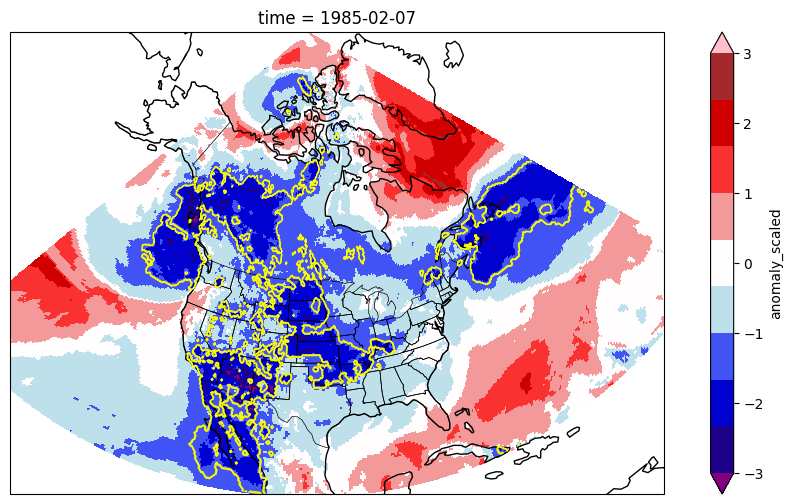

In [7]:
cmap_stdev = colors.LinearSegmentedColormap.from_list("", ["purple","darkblue","blue","lightblue","white","lightcoral","red","darkred","pink"])
z = [-3,-2,-1.5,-1,-0.5,0.5,1,1.5,2,3]
norm = colors.TwoSlopeNorm(vmin=np.min(z), vcenter=0, vmax=np.max(z))

plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
ds.sel(time='1985-02-07')['anomaly_scaled'].plot(transform=ccrs.PlateCarree(),cmap=cmap_stdev,norm=norm,levels=z,extend="both")
ds.sel(time='1985-02-07')['mask'].plot.contour(transform=ccrs.PlateCarree(),colors='yellow',linewidths=0.5)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

Yellow contours highlighting clusters where scaled anomalies < -1.5C

In [8]:
ds["labeled_clusters"] = label_clusters(data_array=ds["mask"])
#ds['area'] = np.cos(ds["latitude"]*np.pi/180)

In [9]:
#ds.groupby('time').groups
ds["labeled_clusters"] =ds['mask'].groupby('time').map(label_clusters)

In [10]:
ds

<xarray.Dataset> Size: 65MB
Dimensions:           (latitude: 281, longitude: 441, time: 31)
Coordinates:
  * latitude          (latitude) float32 1kB 90.0 89.75 89.5 ... 20.5 20.25 20.0
  * longitude         (longitude) float32 2kB -150.0 -149.8 ... -40.25 -40.0
  * time              (time) datetime64[ns] 248B 1970-02-07 ... 2000-02-07
Data variables:
    daily_t2_min      (time, latitude, longitude) float32 15MB ...
    anomaly           (time, latitude, longitude) float32 15MB ...
    anomaly_scaled    (time, latitude, longitude) float32 15MB -0.1574 ... 0....
    mask              (time, latitude, longitude) bool 4MB False False ... False
    labeled_clusters  (time, latitude, longitude) int32 15MB 0 0 0 0 ... 0 0 0 0

## Filter smaller clusters by area

In [11]:
filtered_ds_list = []
for t in ds.time:
    temp_ds = filter_clusters_by_area(data_array=ds["labeled_clusters"].sel(time=t),AREA_THRESHOLD=AREA_THRESHOLD)
    filtered_ds_list.append(temp_ds)

#can assign weights to data_set:
#weights = area_weights(ds["labeled_clusters"])
#ds['weights'] = weights.broadcast_like(data_set)

c:\Users\ls2236\Projects\cao_tracker\.venv\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension labels because variable labels is not a coordinate. To create an index for labels, please first call `.set_coords('labels')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
c:\Users\ls2236\Projects\cao_tracker\.venv\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension labels because variable labels is not a coordinate. To create an index for labels, please first call `.set_coords('labels')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
c:\Users\ls2236\Projects\cao_tracker\.venv\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension labels because variable labels is not a coordinate. To create an index for labels, please first call `.set_coords('labels')` on this object.
  ds.expand_dims(dim_name

In [12]:
mask_for_labels = xr.concat(filtered_ds_list,dim='time')
ds['labeled_masked'] = ds["labeled_clusters"].where(mask_for_labels==1)

In [13]:
ds

<xarray.Dataset> Size: 96MB
Dimensions:           (latitude: 281, longitude: 441, time: 31)
Coordinates:
  * latitude          (latitude) float32 1kB 90.0 89.75 89.5 ... 20.5 20.25 20.0
  * longitude         (longitude) float32 2kB -150.0 -149.8 ... -40.25 -40.0
  * time              (time) datetime64[ns] 248B 1970-02-07 ... 2000-02-07
Data variables:
    daily_t2_min      (time, latitude, longitude) float32 15MB ...
    anomaly           (time, latitude, longitude) float32 15MB ...
    anomaly_scaled    (time, latitude, longitude) float32 15MB -0.1574 ... 0....
    mask              (time, latitude, longitude) bool 4MB False False ... False
    labeled_clusters  (time, latitude, longitude) int32 15MB 0 0 0 0 ... 0 0 0 0
    labeled_masked    (time, latitude, longitude) float64 31MB nan nan ... nan

#### Scaled anomaly

In [14]:
new_cmap = set_white_color(plt.cm.viridis)


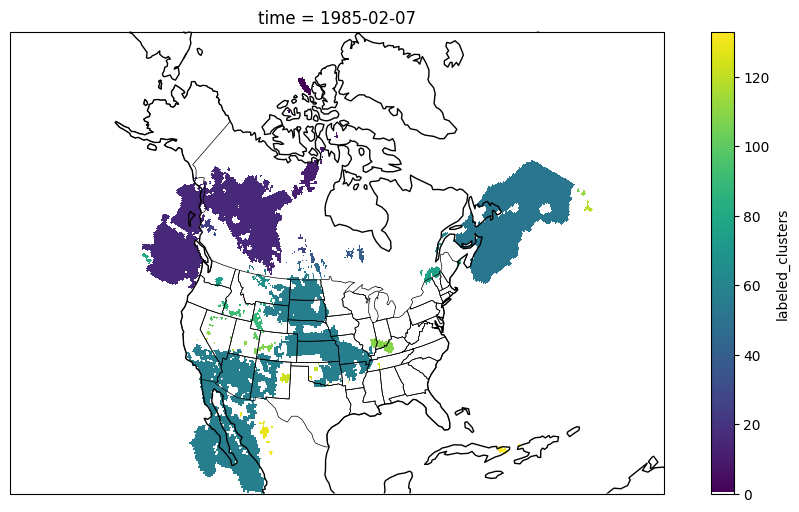

In [15]:
new_cmap = set_white_color(plt.cm.viridis)

plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
ds.sel(time='1985-02-07')['labeled_clusters'].plot(transform=ccrs.PlateCarree(),cmap=new_cmap)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

#### Filtered

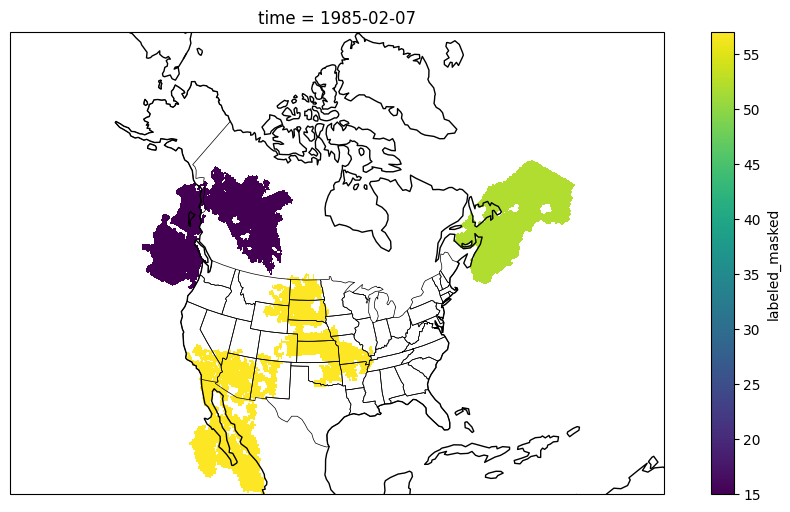

In [16]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
ds.sel(time='1985-02-07')['labeled_masked'].plot(transform=ccrs.PlateCarree())
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

In [17]:
#temp=ds[['labeled_clusters','area']].groupby(('time','labeled_clusters')).sum()
#temp['area'].to_pandas()

## Deforming clusters using binary masks

In [18]:
new_cmap = set_white_color(plt.cm.Set1)

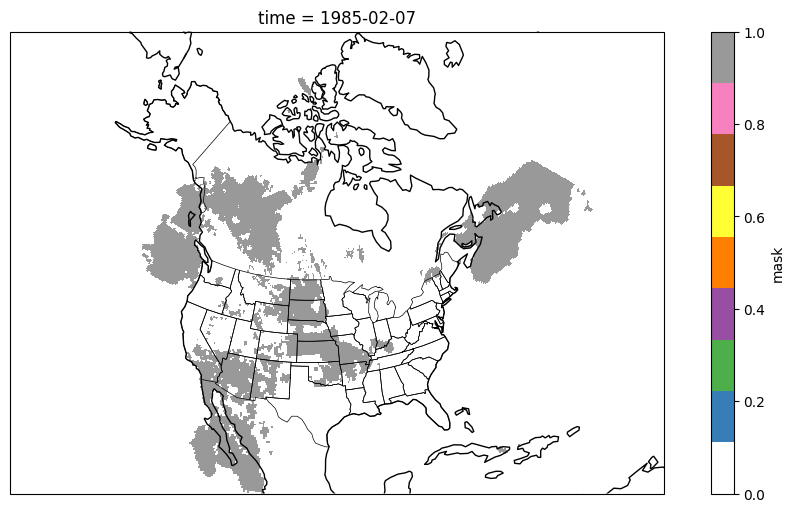

In [19]:
#Original
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
ds["mask"].sel(time='1985-02-07').plot(transform=ccrs.PlateCarree(),cmap=new_cmap)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

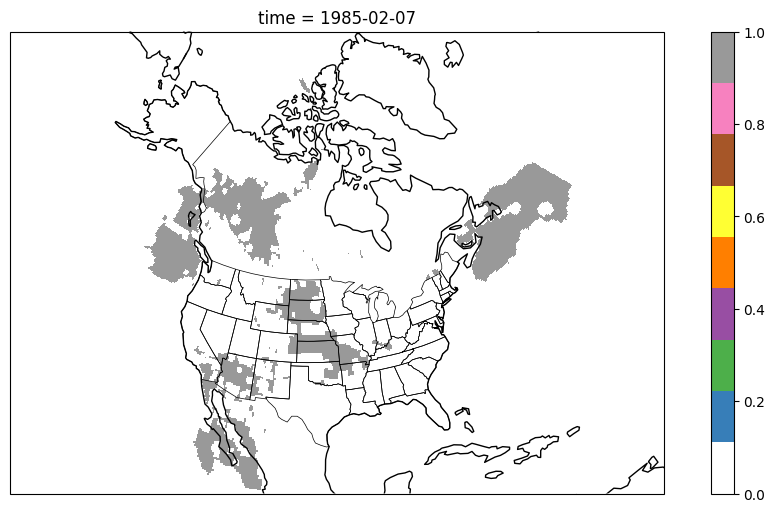

In [20]:
#Erosion
a=apply_binary_morph(ds["mask"].sel(time='1985-02-07'),method='erosion',s=np.ones((3,3)))
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
a.plot(transform=ccrs.PlateCarree(),cmap=new_cmap)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

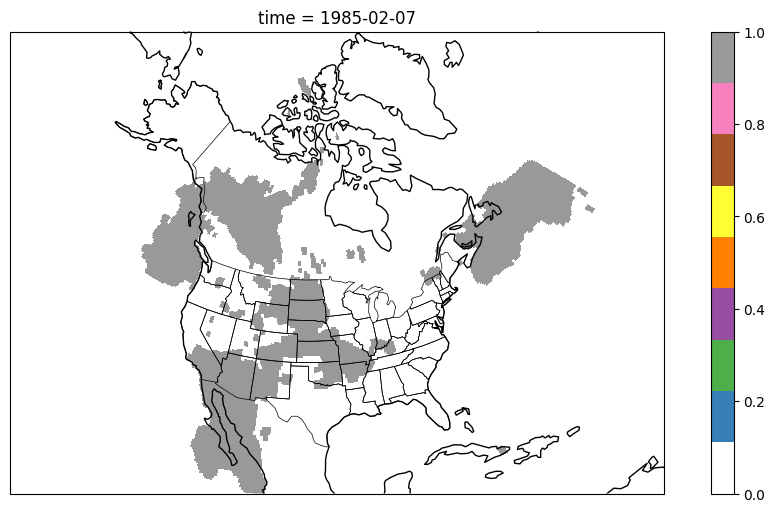

In [21]:
#Sequence of deformations
a = ds["mask"].sel(time='1985-02-07')
a=apply_binary_morph(a,method='closing',s=np.ones((3,3)))
a=apply_binary_morph(a,method='erosion',s=np.ones((2,2)))
a=apply_binary_morph(a,method='dilation',s=np.ones((3,3)))
a=apply_binary_morph(a,method='fill_holes',s=np.ones((3,3)))
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
a.plot(transform=ccrs.PlateCarree(),cmap=new_cmap)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

## Area filtering

In [22]:
ds

<xarray.Dataset> Size: 96MB
Dimensions:           (latitude: 281, longitude: 441, time: 31)
Coordinates:
  * latitude          (latitude) float32 1kB 90.0 89.75 89.5 ... 20.5 20.25 20.0
  * longitude         (longitude) float32 2kB -150.0 -149.8 ... -40.25 -40.0
  * time              (time) datetime64[ns] 248B 1970-02-07 ... 2000-02-07
Data variables:
    daily_t2_min      (time, latitude, longitude) float32 15MB ...
    anomaly           (time, latitude, longitude) float32 15MB ...
    anomaly_scaled    (time, latitude, longitude) float32 15MB -0.1574 ... 0....
    mask              (time, latitude, longitude) bool 4MB False False ... False
    labeled_clusters  (time, latitude, longitude) int32 15MB 0 0 0 0 ... 0 0 0 0
    labeled_masked    (time, latitude, longitude) float64 31MB nan nan ... nan

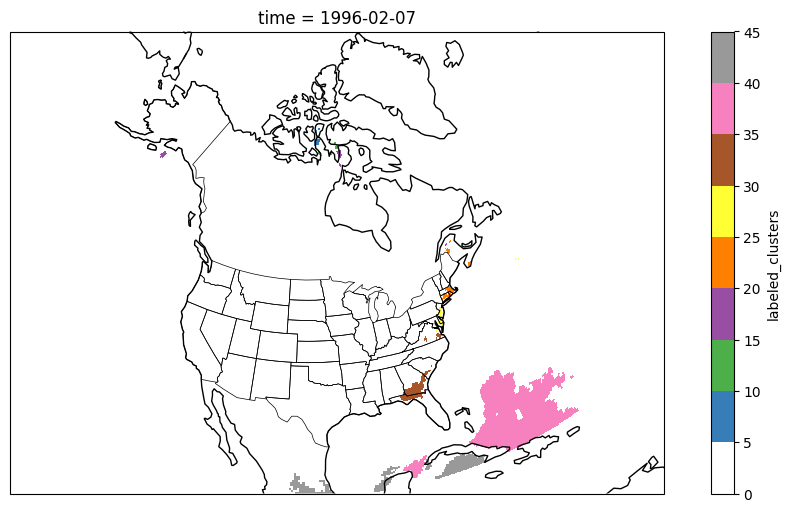

In [23]:
a = ds["labeled_clusters"].sel(time='1996-02-07')
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
a.plot(transform=ccrs.PlateCarree(),cmap=new_cmap)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

c:\Users\ls2236\Projects\cao_tracker\.venv\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension labels because variable labels is not a coordinate. To create an index for labels, please first call `.set_coords('labels')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


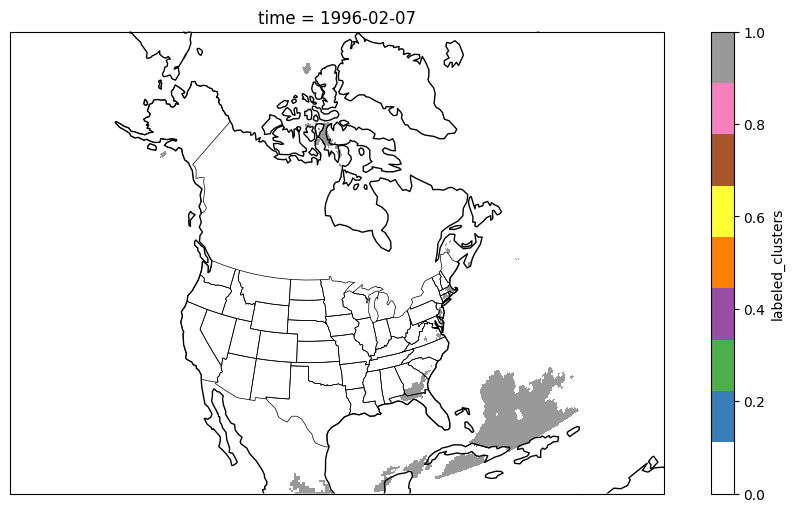

In [24]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
filter_clusters_by_area(a).plot(transform=ccrs.PlateCarree(),cmap=new_cmap)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

## Area coverage

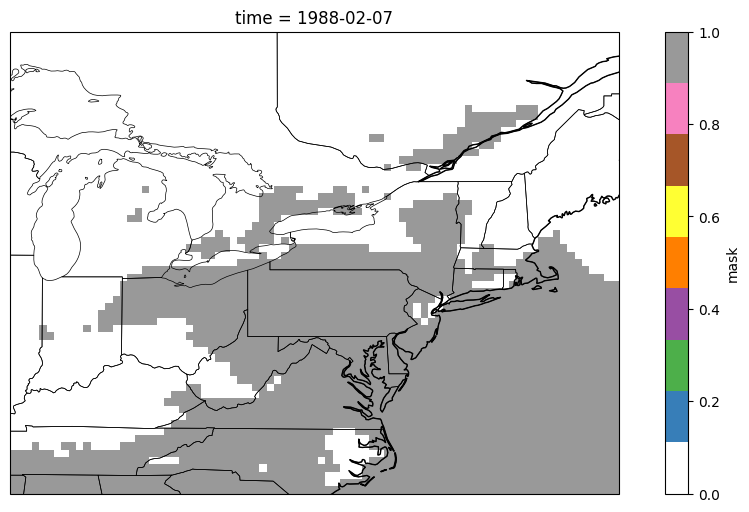

In [91]:
data_set = ds.sel(time='1988-02-07')
data_set = data_set.sel(latitude=slice(50, 34.5), longitude=slice(-88.5, -68))
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.PlateCarree())
data_set['mask'].plot(cmap=new_cmap)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
plt.show()

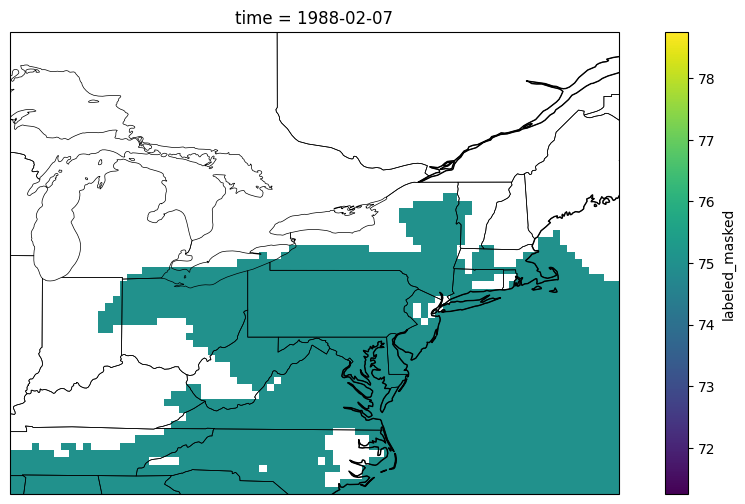

In [92]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.PlateCarree())
data_set['labeled_masked'].plot()
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
plt.show()

In [93]:
#Total domain area
grid_areas = area_weights(data_set['mask'])
data_set['areas'] = grid_areas.broadcast_like(data_set)
total_area = data_set['areas'] .sum()
data_set['areas_weight'] = data_set['areas']/total_area

In [94]:
data_set

<xarray.Dataset> Size: 257kB
Dimensions:           (latitude: 63, longitude: 83)
Coordinates:
  * latitude          (latitude) float32 252B 50.0 49.75 49.5 ... 34.75 34.5
  * longitude         (longitude) float32 332B -88.5 -88.25 ... -68.25 -68.0
    time              datetime64[ns] 8B 1988-02-07
Data variables:
    daily_t2_min      (latitude, longitude) float32 21kB ...
    anomaly           (latitude, longitude) float32 21kB ...
    anomaly_scaled    (latitude, longitude) float32 21kB -0.7667 ... -1.736
    mask              (latitude, longitude) bool 5kB False False ... True True
    labeled_clusters  (latitude, longitude) int32 21kB 0 0 0 0 0 ... 75 75 75 75
    labeled_masked    (latitude, longitude) float64 42kB nan nan ... 75.0 75.0
    G                 (latitude, longitude) float64 42kB 0.0001167 ... 0.02563
    areas             (latitude, longitude) float64 42kB 496.7 496.7 ... 636.9
    areas_weight      (latitude, longitude) float64 42kB 0.0001666 ... 0.0002136

total area under CAO 

In [95]:
data_set.groupby('labeled_masked').sum()['areas']

c:\Users\ls2236\Projects\cao_tracker\.venv\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension labeled_masked because variable labeled_masked is not a coordinate. To create an index for labeled_masked, please first call `.set_coords('labeled_masked')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


<xarray.DataArray 'areas' (labeled_masked: 1)> Size: 8B
array([1282627.78381138])
Coordinates:
    time            datetime64[ns] 8B 1988-02-07
  * labeled_masked  (labeled_masked) float64 8B 75.0
Attributes:
    long_name:  latitude
    units:      degrees_north

total area where scaled anomaly is less than -1.5C

In [96]:
(data_set['mask'].astype(int) * data_set['areas']).sum()

<xarray.DataArray ()> Size: 8B
array(1361989.56956476)
Coordinates:
    time     datetime64[ns] 8B 1988-02-07

## Gaussian filter

In [97]:
def gaussian_filter(data_set,center_lon,center_lat,b=0.05,lat_dim_name="latitude",lon_dim_name="longitude"):
    
    X=data_set[lon_dim_name].broadcast_like(data_set)
    Y=data_set[lat_dim_name].broadcast_like(data_set)
    G = 1/(2*np.pi*b**2) * np.exp(-((np.deg2rad(Y)-np.deg2rad(center_lat))**2 + (np.deg2rad(X)-np.deg2rad(center_lon))**2)/(2*b**2))
    return(G)

In [106]:
data_set["G"] = gaussian_filter(data_set=data_set,center_lon = -75.6,center_lat = 42.9,b=0.18)
data_set['G']  = data_set['G']/np.max(data_set['G'])

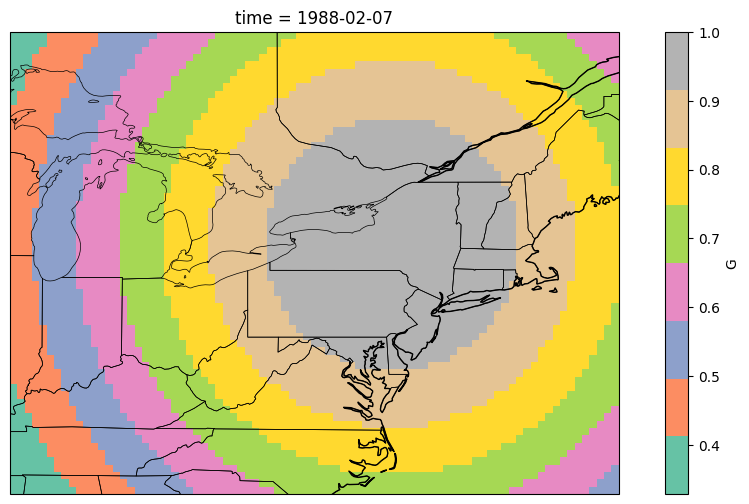

In [107]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.PlateCarree())
data_set['G'].plot(cmap='Set2')
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
plt.show()

## Area coverage using different filters

In [130]:
#Coverage by number of points
total_points = np.size(data_set.latitude) * np.size(data_set.longitude)
(np.sum(data_set['mask'])/total_points).values

array(0.4335437)

In [ ]:
#Coverage weighted by area
total_area = np.sum(data_set['areas'])
(np.sum((data_set['areas']*data_set['mask']))/total_area).values

array(0.45678661)

In [ ]:
#Coverage weighted by gaussian
total_gaussian = np.sum(data_set.G)
(np.sum((data_set['G']*data_set['mask']))/total_gaussian).values

array(0.45949623)